In [ ]:
%pip install sentencepiece

In [ ]:
#!g1.1


In [985]:
#!g1.1
import torch

import pandas as pd
import numpy as np
import math

import nltk

from nltk.tokenize import word_tokenize, wordpunct_tokenize


%pip install --upgrade transformers datasets accelerate deepspeed
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
# import datasets

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moto 1.3.14 requires idna<2.9,>=2.5, but you have idna 3.4 which is incompatible.
kaggle 1.5.8 requires urllib3<1.25,>=1.21.1, but you have urllib3 1.26.15 which is incompatible.
cloud-ml 0.0.1 requires requests<=2.25.1,>=2.22.0, but you have requests 2.28.2 which is incompatible.
cloud-ml 0.0.1 requires tqdm<=4.54.1,>=4.45.0, but you have tqdm 4.65.0 which is incompatible.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [986]:
#!g1.1
import matplotlib.pyplot as plt
%matplotlib inline
import json
from IPython.display import clear_output
import copy

In [ ]:
#!g1.1
import os
# TOKENIZERS_PARALLELISM=(true | false)
os.environ["TOKENIZERS_PARALLELISM"] = 'true'

In [987]:
#!g1.1
# model_name = "Tatyana/rubert-base-cased-sentiment-new"
# tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

# base_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)


model_name = "cointegrated/rubert-tiny"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

base_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [878]:
#!g1.1
# base_model

In [989]:
#!g1.1
DATA_PATH = '/home/jupyter/mnt/s3/dataset_hackaton/'

In [880]:
#!g1.1
!ls /home/jupyter/mnt/s3/dataset_hackaton/

Execute error: Servant c1.4 not allocated: Internal Error

bank-categories.csv
bank-sentiment.csv
banki.csv
banks-ethic-DB - NEW.docx
homework_shad_da.ipynb.txt
model_1.pth
model_2.pth
model_3.pth
relations.html
sentiment.csv
train.csv
train_OHE.csv


In [1001]:
#!g1.1
train_df = pd.read_csv(DATA_PATH + 'train_OHE.csv')

dop_df = pd.read_csv(DATA_PATH + 'dop_df_en_ru.csv')

bank_categories_df = pd.read_csv(DATA_PATH + 'bank-sentiment.csv')
bank_sentiment_df = pd.read_csv(DATA_PATH + 'bank-categories.csv')


In [1002]:
#!g1.1
# bank_categories_df

In [1003]:
#!g1.1
train_df

,Unnamed: 0,Unnamed: 0.1,sentence,1category,2category,sentiment
0,0,4754,При этом всегда получал качественные услуги.,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0, 0]"
1,1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
2,2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
3,3,11640,Отвратительное отношение к клиентам.,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
4,4,5571,"Всегда в любое время дня и ночи помогут, ответ...","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0, 0]"
...,...,...,...,...,...,...
19356,19356,8004,Никогда и ни в коем случае не открывайте счет ...,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
19357,19357,18182,ТИ откровенно забили на качество и развивают с...,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
19358,19358,744,"Я считаю, это прорыв и лидерство финансовых ус...","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0, 0]"
19359,19359,6220,"Писал мужчина очень доходчиво, не финансовым я...","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0, 0]"


In [1004]:
#!g1.1
# indexes = np.arange(train_df.shape[0])
# np.random.shuffle(indexes)
# train_size = math.ceil(train_df.shape[0] * 0.8)

# train_indexes = indexes[:train_size]
# test_indexes = indexes[train_size:]

# train_data = train_df.iloc[train_indexes]
# test_data = train_df.iloc[test_indexes]

# train_data.reset_index(drop=True, inplace=True)
# test_data.reset_index(drop=True, inplace=True)


indexes = np.arange(train_df.shape[0])
np.random.shuffle(indexes)
train_size = math.ceil(train_df.shape[0] * 0.8)

data = train_df.iloc[indexes]

train_data = train_df.iloc[indexes].iloc[:train_size, :]
test_data = train_df.iloc[indexes].iloc[train_size:, :]

In [1005]:
#!g1.1
len(train_data)

15489

In [1006]:
#!g1.1
train_data = train_data.merge(dop_df, how='outer')
train_data['is_syntetic'] = train_data['is_syntetic'].fillna(0)

indexes = np.arange(train_data.shape[0])
np.random.shuffle(indexes)

train_data = train_data.iloc[indexes]


In [1008]:
#!g1.1
# len(train_data)

In [1009]:
#!g1.1
MAX_LENGTH = 200
def preprocess_function(examples):
    result = tokenizer(
        examples,
        padding='max_length', max_length=MAX_LENGTH, truncation=True
    )
#     result['target'] = examples['target']
    return result

In [1024]:
#!g1.1
from torch.utils.data import Dataset, random_split


class Dataset(Dataset):
    def __init__(self, data: pd.DataFrame, feature_column: str, target_columns: list, tokenizer):  
        self.data = data
        self.tokenizer = tokenizer

        self.feature_column = feature_column
        self.target_columns = target_columns
        self.label2list = lambda x: [int(i) for i in json.loads(x)]
#         if dop_features is None:
#             self.dop_features = []
#         else:
#             self.dop_features = dop_features
        

    def __getitem__(self, item):
        indx_tokens = preprocess_function(self.data[self.feature_column].iloc[item])
        d = {}
        for label in self.target_columns:
            d[f'target_{label}'] = self.label2list(self.data[label].iloc[item])
            
        return {**indx_tokens, **d}

    def get_tokens_(self, text):
          return self.tokenizer(text)

    def __len__(self):
        return self.data.shape[0]
    
    

In [1025]:
#!g1.1
train_df

,Unnamed: 0,Unnamed: 0.1,sentence,1category,2category,sentiment
0,0,4754,При этом всегда получал качественные услуги.,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0, 0]"
1,1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
2,2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
3,3,11640,Отвратительное отношение к клиентам.,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
4,4,5571,"Всегда в любое время дня и ночи помогут, ответ...","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0, 0]"
...,...,...,...,...,...,...
19356,19356,8004,Никогда и ни в коем случае не открывайте счет ...,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
19357,19357,18182,ТИ откровенно забили на качество и развивают с...,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0]","[0, 0, 1]"
19358,19358,744,"Я считаю, это прорыв и лидерство финансовых ус...","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0, 0]"
19359,19359,6220,"Писал мужчина очень доходчиво, не финансовым я...","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 0, 0]"


In [1026]:
#!g1.1
train_dataset = Dataset(train_data, 'sentence', ['1category', '2category', 'sentiment'], tokenizer)

test_dataset = Dataset(test_data, 'sentence', ['1category', '2category', 'sentiment'], tokenizer)

In [1027]:
#!g1.1
example = train_dataset[0]

In [181]:
#!g1.1
# tokenizer.decode(example['input_ids'])

In [ ]:
#!g1.1


In [92]:
#!g1.1


0

In [1028]:
#!g1.1
from torch.utils.data import DataLoader


batch_size = 32
num_workers = 8

def average_emb(batch):
    features = [b["tokens"] for b in batch]
    targets = [b["target"] for b in batch]

    return {"tokens": features, "targets": torch.LongTensor(targets)}


# train_size = math.ceil(len(dataset) * 0.8)

# train, valid = random_split(dataset, [train_size, len(train_data) - train_size])
# train, valid = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True, collate_fn=transformers.default_data_collator)
valid_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False, collate_fn=transformers.default_data_collator)

In [1030]:
#!g1.1
# batch = next(iter(valid_loader))

In [1032]:
#!g1.1
# batch

In [1033]:
#!g1.1
# model(batch['input_ids'], batch['attention_mask'])

In [1040]:
#!g1.1
device = 'cuda'

In [1041]:
#!g1.1
newmodel = copy.deepcopy(base_model)
newmodel = torch.nn.Sequential(*(list(newmodel.children())[:-1]))[0]

In [1042]:
#!g1.1
# outp = newmodel(batch['input_ids'], batch['attention_mask'])

In [1043]:
#!g1.1
# outp.pooler_output.shape

In [1044]:
#!g1.1
s = 0
for layer in base_model.parameters():
    s += layer.requires_grad
    layer.requires_grad = False
s

0

In [1045]:
#!g1.1
_ = base_model.to(device)

In [1046]:
#!g1.1
def freeze_layers(model, num_to_freeze=0):
    
    for layer in list(model.parameters())[:-num_to_freeze]:
        layer.requires_grad = False
#         print(layer.requires_grad)
    return model
        

In [1047]:
#!g1.1


class Cls_head(nn.Module):
    
    def __init__(self, last_layer_dim=1024, hidden_layer_size=512, out_size=1):
        super().__init__()
        self.last_layer_dim = last_layer_dim
        self.hidden_layer_size = hidden_layer_size,
        self.out_size = out_size
        
        self.hidden_layer_1 = nn.Linear(last_layer_dim, hidden_layer_size)
        self.relu1 = nn.ReLU(inplace=True)
        self.bn_1 = nn.BatchNorm1d(hidden_layer_size)
        
        self.hidden_layer_2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.relu2 = nn.ReLU(inplace=True)
#         self.bn_2 = nn.BatchNorm1d(hidden_layer_size)
        self.dropout2 = nn.Dropout(p=0.3)
        
        
        self.hidden_layer_3 = nn.Linear(hidden_layer_size, hidden_layer_size // 4)
        self.relu3 = nn.ReLU(inplace=True)
        self.bn_3 = nn.BatchNorm1d(hidden_layer_size // 4)
        
        self.cls = nn.Linear(hidden_layer_size // 4, out_size)
        
        
        
    def forward(self, x):
        
        out = self.bn_1(self.relu1(self.hidden_layer_1(x)))
#         out = self.bn_2(self.relu2(self.hidden_layer_2(out)))
        out = self.dropout2(self.relu2(self.hidden_layer_2(out)))
        out = self.bn_3(self.relu3(self.hidden_layer_3(out)))
        out = self.cls(out)
        
        return out
        

class FBERTAcls(nn.Module):

    def __init__(self, model, last_layer_dim=768, hidden_layer_size=256):
        super().__init__()
        
        
        self.BERT = freeze_layers(model, 20)
        
        self.cls_head_1 = Cls_head(last_layer_dim=last_layer_dim, hidden_layer_size=hidden_layer_size, out_size=3)
        self.cls_head_2 = Cls_head(last_layer_dim=last_layer_dim, hidden_layer_size=hidden_layer_size, out_size=5)
        
        
        

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        bert_output = self.BERT(input_ids=input_ids, attention_mask=attention_mask)
#         hidden_out = self.hidden_layer_1(bert_output.last_hidden_state[:, 0, :])

#         print(bert_output.shape)

        bert_output = bert_output.pooler_output
#         print(bert_output.shape)
#         print(bert_output.sum())
        sent_logits = self.cls_head_1(bert_output) 
        
        cat_1_logits = self.cls_head_2(bert_output)

        return sent_logits, cat_1_logits




In [1048]:
#!g1.1
model = FBERTAcls(newmodel, last_layer_dim=312, hidden_layer_size=1024).cpu()

In [1049]:
#!g1.1
s = 0
num_of_freezed_layer = 0
for layer in model.parameters():
    print(layer.requires_grad)
    s += layer.requires_grad
    if not layer.requires_grad:
        num_of_freezed_layer += 1
    
s

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


24

In [1050]:
#!g1.1
# model.eval()
# model(batch['input_ids'], batch['attention_mask'])

In [1051]:
#!g1.1
num_of_freezed_layer

55

In [1052]:
#!g1.1
num_diff_layers = len(list(model.parameters())) - len(list(newmodel.parameters()))

In [1053]:
#!g1.1
device = 'cuda'

In [1055]:
#!g1.1
# batch = next(iter(train_loader))
# list(batch.keys())

In [907]:
#!g1.1
# model(batch['input_ids'], batch['attention_mask'])

In [1056]:
#!g1.1
#!g1.1

def models_loss(model1, model2):
    
    l1_loss = nn.L1Loss()
    
    m1_params = list(model1.parameters())
    m2_params = list(model2.parameters())
    
    loss = torch.tensor(0, dtype=torch.float32, requires_grad=True).to(device)
    
    for i, layer in enumerate(m1_params[:-num_diff_layers]):
        if layer.requires_grad:
            loss += l1_loss(layer.data, m2_params[i].data.detach())
#             print(layer.requires_grad)
            
    return loss


def compute_loss(logits_sent, logits_1cat, targets_sent, targets_1cat, model1=None, model2=None):
    ce_loss = nn.CrossEntropyLoss()
    
    if model1 is None:
        loss = ce_loss(logits_sent, targets_sent) + 0.5 * ce_loss(logits_1cat, targets_1cat)
        return loss
    
    loss = ce_loss(logits_sent, targets_sent) + 0.5 * ce_loss(logits_1cat, targets_1cat) + 0.5 * models_loss(model1, model2)
    
    return loss
    
    

In [1057]:
#!g1.1
from tqdm.notebook import tqdm

# ['input_ids',
#  'token_type_ids',
#  'attention_mask',
#  'target_1category',
#  'target_2category',
#  'target_sentiment']


def training(model, optimizer, criterion, train_loader, epoch, device="cpu", scheduler=None):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}. Train Loss: {0}")
    
    model.train()
    
    total_loss = 0
    steps = 0
    
    count = 0
    for batch in pbar:
        optimizer.zero_grad()
        
        features = batch["input_ids"].to(device)
        attn_mask = batch['attention_mask'].to(device)
        
        targets_sent = torch.argmax(batch["target_sentiment"].to(device), dim=-1)
        targets_1cat = torch.argmax(batch["target_1category"].to(device), dim=-1)

        sent_logits, cat_logits = model(features, attn_mask)
#         print(sent_logits)
        
        loss = compute_loss(sent_logits, cat_logits, targets_sent, targets_1cat, model, base_model)
        
        loss.backward()

        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        total_loss += loss.detach().cpu()
        
        pbar.set_description(f"Epoch {epoch + 1}. Train Loss: {loss.detach().cpu():.4}")
        steps += 1
        
    return total_loss.item() / steps


In [1058]:
#!g1.1
def testing(model, criterion, test_loader, threshold=0.5, device="cpu"):
    pbar = tqdm(test_loader, desc=f"Test Loss: {0}, Test Acc: {0}")
    mean_loss = 0
    mean_acc = 0
    model.eval()
    
    
    all_probs_sent = []
    all_probs_1cat = []
    
    target_labels_sent = []
    target_labels_sent_1cat = []
    
    with torch.no_grad():
        for batch in pbar:
            
            features = batch["input_ids"].to(device)
            attn_mask = batch['attention_mask'].to(device)
        
            targets_sent = torch.argmax(batch["target_sentiment"].to(device), dim=-1)
            targets_1cat = torch.argmax(batch["target_1category"].to(device), dim=-1)

            sent_logits, cat_logits = model(features, attn_mask)
#             print(sent_logits)
            
            target_labels_sent.append(batch["target_sentiment"].cpu().numpy())
            target_labels_sent_1cat.append(batch["target_1category"].cpu().numpy())
            
            all_probs_sent.append(torch.softmax(sent_logits, dim=-1).cpu().numpy())
            all_probs_1cat.append(torch.softmax(cat_logits, dim=-1).cpu().numpy())
            
            loss = compute_loss(sent_logits, cat_logits, targets_sent, targets_1cat)

#             predict = probas.cpu() > threshold
#             acc = (predict.cpu() == targets.cpu()).sum() / len(targets)

            mean_loss += loss.item()
#             mean_acc += acc.item()

#             pbar.set_description(f"Test Loss: {loss:.4}, Test Acc: {acc:.4}")

#     pbar.set_description(f"Test Loss: {mean_loss / len(test_loader):.4}, Test Acc: {mean_acc / len(test_loader):.4}")
    return {'all_probs_sent': all_probs_sent,
            'all_probs_1cat': all_probs_1cat, 
           'target_sent': target_labels_sent,
           'target_1cat': target_labels_sent_1cat}
#     return {"Test Loss": mean_loss / len(test_loader), "Test Acc": mean_acc / len(test_loader), 'target_labels': target_labels, 'probs': all_probs}


In [1059]:
#!g1.1

device = 'cuda:0'

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

criterion = nn.BCEWithLogitsLoss()

torch.cuda.is_available()


True

In [1060]:
#!g1.1
# batch = next(iter(train_loader))

[1.3377753224460986]


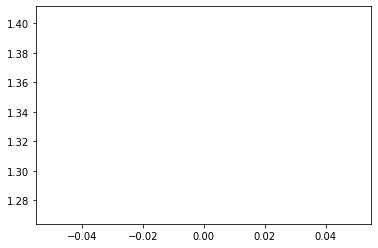

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-77-a3ac3237dd00>:13 in <module>                                            │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'unfreeze_one_layer' is not defined

In [1061]:
#!g1.1
losses = []
print(device)

for epoch in range(20):
    loss = training(model, optimizer, criterion, train_loader, epoch, device, scheduler=scheduler)
    losses.append(loss)
    clear_output(wait=True)
    print(losses)
    plt.plot(list(range(epoch + 1)), losses)
    plt.show()
    
    if epoch % 5 == 0:
        unfreeze_one_layer(model, num_of_freezed_layer)
        num_of_freezed_layer += 1
    

In [978]:
#!g1.1
t  = testing(model, criterion, valid_loader, 0.5, device)

Test Loss: 0, Test Acc: 0:   0%|          | 0/121 [00:00<?, ?it/s]

In [979]:
#!g1.1
list(t.keys())

['all_probs_sent', 'all_probs_1cat', 'target_sent', 'target_1cat']

In [980]:
#!g1.1
all_probs_sent = np.array(t['all_probs_sent'])
all_probs_1cat = np.array(t['all_probs_1cat'])
target_sent = np.array(t['target_sent'])
target_1cat = np.array(t['target_1cat'])



In [981]:
#!g1.1
target_1cat.shape

(121, 32, 5)

In [982]:
#!g1.1

target_sent = target_sent.reshape(-1, 1, 3).squeeze()
target_1cat = target_1cat.reshape(-1, 1, 5).squeeze()

all_probs_1cat = all_probs_1cat.reshape(-1, 1, 5).squeeze()
all_probs_sent = all_probs_sent.reshape(-1, 1, 3).squeeze()

In [983]:
#!g1.1
target_1cat.shape

(3872, 5)

In [984]:
#!g1.1
from sklearn.metrics import roc_auc_score



print('+ score:', roc_auc_score(target_sent[:, 0], all_probs_sent[:, 0]))
print('? score:', roc_auc_score(target_sent[:, 1], all_probs_sent[:, 1]))
print('- score', roc_auc_score(target_sent[:, 2], all_probs_sent[:, 2]))

+ score: 0.9606576208889988
? score: 0.8664687931331954
- score 0.9580215831574079


In [542]:
#!g1.1
all_probs_sent.shape

(3872, 3)

In [543]:
#!g1.1

In [848]:
#!g1.1
torch.save(model.state_dict(), DATA_PATH + 'model_3.pth')

In [422]:
#!g1.1
DATA_PATH

'/home/jupyter/mnt/s3/dataset_hackaton/'

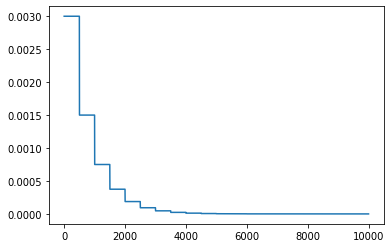

In [499]:
#!g1.1
qq = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(qq.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
lrs = []

for e in range(10):
    for i in range(1000):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
    #     print("Factor = ",0.1 if i!=0 and i%2!=0 else 1," , Learning Rate = ",optimizer.param_groups[0]["lr"])
        scheduler.step()

plt.plot(range(10000),lrs)

In [500]:
#!g1.1
np.array(lrs) < 1e-6

array([False, False, False, ...,  True,  True,  True])

In [696]:
#!g1.1
s = 0
for p in base_model.parameters():
    s += p.requires_grad
#     print(p.requires_grad)
    p.requires_grad = False
s

57

In [721]:
#!g1.1
m_params = list(model.parameters())
bm_params = list(base_model.to(device).parameters())

In [973]:
#!g1.1

def unfreeze_one_layer(model, num_of_freezed_layer):
    layers = list(model.parameters())
    
    if len(layers) < num_of_freezed_layer:
        return
    
    layers[num_of_freezed_layer - 1].requires_grad = True
    

In [951]:
#!g1.1
num_of_freezed_layer

35

In [954]:
#!g1.1
unfreeze_one_layer(model, num_of_freezed_layer)

In [955]:
#!g1.1
s = 0

for p in model.parameters():
    s += p.requires_grad
s

45

In [794]:
#!g1.1
# l.requires_grad = True
l.requires_grad

True

In [795]:
#!g1.1
l.backward()

In [ ]:
#!g1.1
